In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
from data_parser import data_loader_full
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
file_path = 'Predicted/results.pkl'
with open(file_path, 'rb') as pickle_file:
    pred = pickle.load(pickle_file)

In [3]:
data_occupancy_all, data_flow_all, data_speed_all = data_loader_full()
X_occu_all, y_occu_all = data_occupancy_all[:, :2], data_occupancy_all[:, 2]
X_occu_all, y_occu_all = torch.tensor(X_occu_all, dtype=torch.float32, requires_grad=True).to(device), torch.tensor(y_occu_all, dtype=torch.float32).unsqueeze(1).to(device)

In [4]:
occupancy_recon = torch.cat((X_occu_all, pred['occupancy_recon']), dim=1).detach().numpy()
flow_recon = torch.cat((X_occu_all, pred['flow_recon']), dim=1).detach().numpy()
speed_recon = torch.cat((X_occu_all, pred['speed_recon']), dim=1).detach().numpy()

k_t = torch.cat((X_occu_all, pred['k_t']), dim=1).detach().numpy()

k_x = torch.cat((X_occu_all, pred['k_x']), dim=1).detach().numpy()
q_x = torch.cat((X_occu_all, pred['q_x']), dim=1).detach().numpy()
v_x = torch.cat((X_occu_all, pred['v_x']), dim=1).detach().numpy()

k_t_predict = torch.cat((X_occu_all, pred['k_t_predict']), dim=1).detach().numpy()

# k_xx = torch.cat((X_occu_all, pred['k_xx']), dim=1).detach().numpy()
# q_xx = torch.cat((X_occu_all, pred['q_xx']), dim=1).detach().numpy()
# v_xx = torch.cat((X_occu_all, pred['v_xx']), dim=1).detach().numpy()

occupancy_recon = pd.DataFrame(occupancy_recon, columns = ['TimeStep','Station_Number','Occupancy'])
flow_recon = pd.DataFrame(flow_recon, columns = ['TimeStep','Station_Number','Flow'])
speed_recon = pd.DataFrame(speed_recon, columns = ['TimeStep','Station_Number','Speed'])

k_t = pd.DataFrame(k_t, columns = ['TimeStep','Station_Number','k_t'])

k_x = pd.DataFrame(k_x, columns = ['TimeStep', 'Station_Number', 'k_x'])
q_x = pd.DataFrame(q_x, columns = ['TimeStep', 'Station_Number', 'q_x'])
v_x = pd.DataFrame(v_x, columns = ['TimeStep', 'Station_Number', 'v_x'])

k_t_predict = pd.DataFrame(k_t_predict, columns=['TimeStep', 'Station_Number', 'k_t'])

# k_xx = pd.DataFrame(k_xx, columns = ['TimeStep', 'Station_Number', 'k_xx'])
# q_xx = pd.DataFrame(q_xx, columns = ['TimeStep', 'Station_Number', 'q_xx'])
# v_xx = pd.DataFrame(v_xx, columns = ['TimeStep', 'Station_Number', 'v_xx'])


In [5]:
Flow = pd.read_csv('Data_Clean/Flow_all.csv',index_col='Station_PM')
Occupancy = pd.read_csv('Data_Clean/Occupancy_all.csv',index_col='Station_PM')
Speed = pd.read_csv('Data_Clean/Speed_all.csv',index_col='Station_PM')

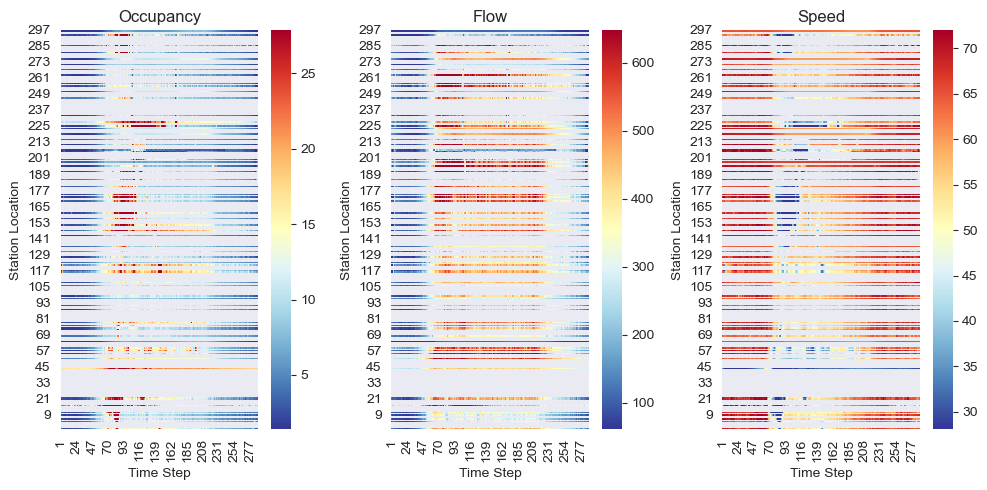

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# y_tick_positions = range(10, 288, 10)  # Adjust as needed
# y_tick_labels = [str(val) for val in y_tick_positions]

sns.heatmap(100*Occupancy.iloc[:,:288].iloc[::-1], cmap="RdYlBu_r", annot=False, robust=True, ax=axs[0])
axs[0].set_ylabel('Station Location')
axs[0].set_xlabel('Time Step')
axs[0].set_title("Occupancy")

sns.heatmap(Flow.iloc[:,:288].iloc[::-1], cmap="RdYlBu_r", annot=False,robust=True, ax=axs[1])
axs[1].set_ylabel('Station Location')
axs[1].set_xlabel('Time Step')
axs[1].set_title("Flow")

sns.heatmap(Speed.iloc[:,:288].iloc[::-1], cmap="RdYlBu_r", annot=False,robust=True, ax=axs[2])
axs[2].set_ylabel('Station Location')
axs[2].set_xlabel('Time Step')
axs[2].set_title("Speed")


plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()

fig.savefig("Figures/Heatmap.png", dpi = 300)

## Plot Reconstructed Data

In [7]:
occupancy_recon['TimeStep'] = occupancy_recon['TimeStep'].astype(int)
occupancy_recon['Station_Number'] = occupancy_recon['Station_Number'].astype(int)
flow_recon['TimeStep'] = flow_recon['TimeStep'].astype(int)
flow_recon['Station_Number'] = flow_recon['Station_Number'].astype(int)
speed_recon['TimeStep'] = speed_recon['TimeStep'].astype(int)
speed_recon['Station_Number'] = speed_recon['Station_Number'].astype(int)

In [8]:
occupancy_recon_wide = occupancy_recon.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
flow_recon_wide = flow_recon.pivot(index='Station_Number', columns='TimeStep', values='Flow')
speed_recon_wide = speed_recon.pivot(index='Station_Number', columns='TimeStep', values='Speed')

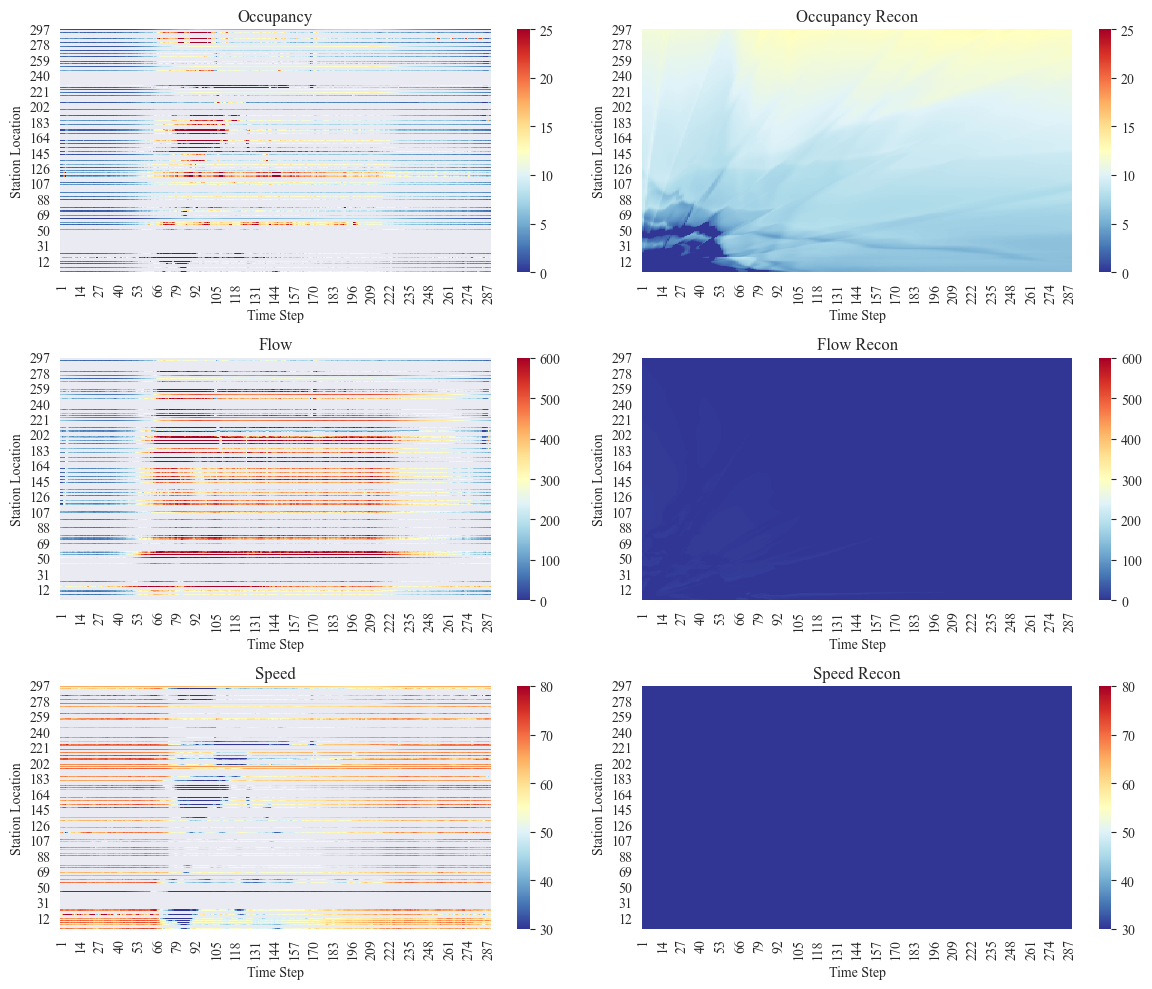

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

vmin1_occu, vmax1_occu = 0, 25

occu_heat_1 = sns.heatmap(100*Occupancy.iloc[:,:288].iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=axs[0,0])
axs[0,0].set_ylabel('Station Location')
axs[0,0].set_xlabel('Time Step')
axs[0,0].set_title("Occupancy")

occu_heat_2 = sns.heatmap(occupancy_recon_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=axs[0,1])
axs[0,1].set_ylabel('Station Location')
axs[0,1].set_xlabel('Time Step')
axs[0,1].set_title("Occupancy Recon")

vmin1_flow, vmax1_flow = 0, 600

sns.heatmap(Flow.iloc[:,:288].iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_flow, vmax=vmax1_flow, annot=False, ax=axs[1,0])
axs[1,0].set_ylabel('Station Location')
axs[1,0].set_xlabel('Time Step')
axs[1,0].set_title("Flow")

sns.heatmap(flow_recon_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_flow, vmax=vmax1_flow, annot=False, ax=axs[1,1])
axs[1,1].set_ylabel('Station Location')
axs[1,1].set_xlabel('Time Step')
axs[1,1].set_title("Flow Recon")

vmin1_speed, vmax1_speed = 30, 80

sns.heatmap(Speed.iloc[:,:288].iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_speed, vmax=vmax1_speed, annot=False, ax=axs[2,0])
axs[2,0].set_ylabel('Station Location')
axs[2,0].set_xlabel('Time Step')
axs[2,0].set_title("Speed")

sns.heatmap(speed_recon_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_speed, vmax=vmax1_speed, annot=False, ax=axs[2,1])
axs[2,1].set_ylabel('Station Location')
axs[2,1].set_xlabel('Time Step')
axs[2,1].set_title("Speed Recon")

plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()

fig.savefig("Figures/Heatmap_all.png", dpi = 300)

In [26]:
k_t['TimeStep'] = k_t['TimeStep'].astype(int)
k_t['Station_Number'] = k_t['Station_Number'].astype(int)

k_t_predict['TimeStep'] = k_t_predict['TimeStep'].astype(int)
k_t_predict['Station_Number'] = k_t_predict['Station_Number'].astype(int)

k_x['TimeStep'] = k_x['TimeStep'].astype(int)
k_x['Station_Number'] = k_x['Station_Number'].astype(int)

q_x['TimeStep'] = q_x['TimeStep'].astype(int)
q_x['Station_Number'] = q_x['Station_Number'].astype(int)

v_x['TimeStep'] = v_x['TimeStep'].astype(int)
v_x['Station_Number'] = v_x['Station_Number'].astype(int)

In [27]:
k_t_wide = k_t.pivot(index='Station_Number', columns='TimeStep', values='k_t')
k_t_predict_wide = k_t_predict.pivot(index='Station_Number', columns='TimeStep', values='k_t')

k_x_wide = k_x.pivot(index='Station_Number', columns='TimeStep', values='k_x')

q_x_wide = q_x.pivot(index='Station_Number', columns='TimeStep', values='q_x')

v_x_wide = v_x.pivot(index='Station_Number', columns='TimeStep', values='v_x')

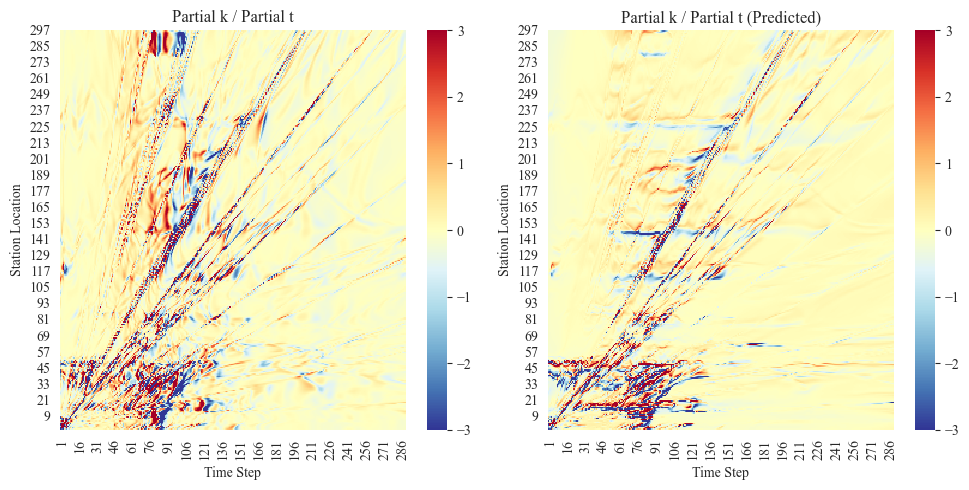

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

vmin, vmax = -3, 3
sns.heatmap(k_t_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin, vmax=vmax, annot=False, robust=True, ax=axs[0])
axs[0].set_ylabel('Station Location')
axs[0].set_xlabel('Time Step')
axs[0].set_title("Partial k / Partial t")

sns.heatmap(k_t_predict_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin, vmax=vmax, annot=False,robust=True, ax=axs[1])
axs[1].set_ylabel('Station Location')
axs[1].set_xlabel('Time Step')
axs[1].set_title("Partial k / Partial t (Predicted)")

plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()

fig.savefig("Figures/k_dev.png", dpi = 300)

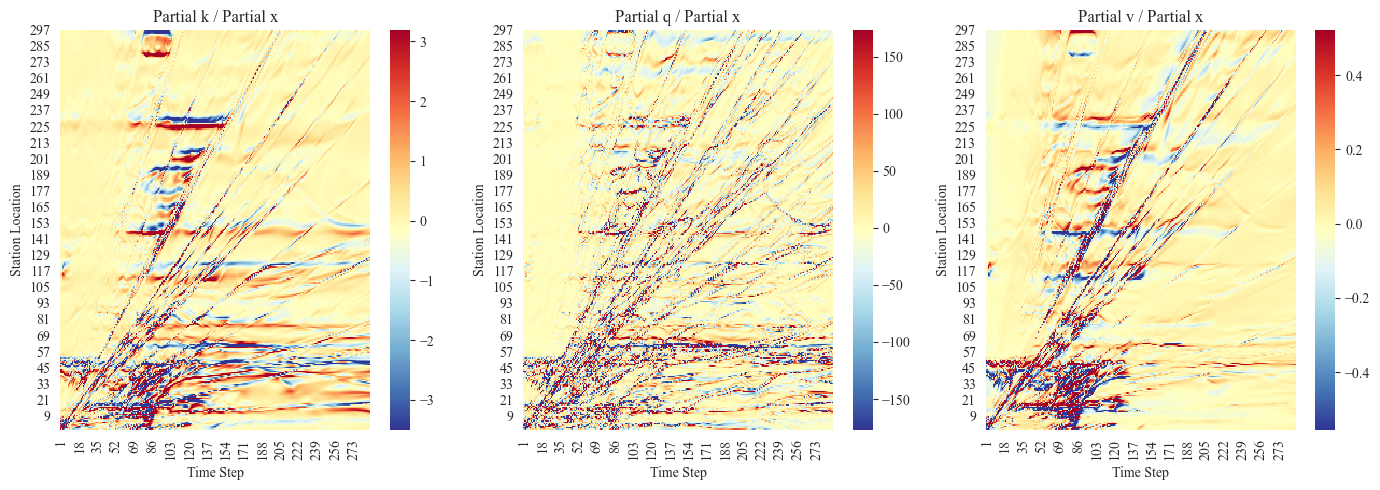

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

sns.heatmap(k_x_wide.iloc[::-1], cmap="RdYlBu_r", annot=False,robust=True, ax=axs[0])
axs[0].set_ylabel('Station Location')
axs[0].set_xlabel('Time Step')
axs[0].set_title("Partial k / Partial x")

sns.heatmap(q_x_wide.iloc[::-1], cmap="RdYlBu_r", annot=False,robust=True, ax=axs[1])
axs[1].set_ylabel('Station Location')
axs[1].set_xlabel('Time Step')
axs[1].set_title("Partial q / Partial x")

sns.heatmap(v_x_wide.iloc[::-1], cmap="RdYlBu_r", annot=False,robust=True, ax=axs[2])
axs[2].set_ylabel('Station Location')
axs[2].set_xlabel('Time Step')
axs[2].set_title("Partial v / Partial x")

plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()

fig.savefig("Figures/qv_dev.png", dpi = 300)